# Value at Risk portfolio example S&P500
Implementation of four VaR estimations: VaR with EWMA volatility, VaR with MA volatility, VaR with GARCH(1,1) volatility and historical simulation VaR. Backtesting using unconditional coverage test and violation ratios. 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm,chi2, binom
import itertools
from arch import arch_model
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### VaR Estimation

In [2]:
#Download data
data_ex1=yf.download('^GSPC',start='1994-02-10',end='2010-1-1')['Adj Close']

#Compute log returns
ret_ex1=np.log(data_ex1/data_ex1.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


In [3]:
#Helper function: estimate EWMA volatility
def EWMA(returns,lmbda):
    
    #Create a series with shifted squared returns 
    ewma_var=(returns**2).shift(1)
    
    #Incorporate the variance of the total sample to initialize EWMA
    ewma_var.iloc[1]=returns.var()
    ewma_var.dropna(inplace=True)
    
    #Loop the formula of EWMA (lmbda*var_t-1 + (1-lmbda)*ret_t-1^2)
    loop_formula=itertools.accumulate(ewma_var.to_numpy(), lambda a,b: a*lmbda+b*(1-lmbda))
    
    #Pass the iteration element to a series
    ewma_var=pd.Series(list(loop_formula),index=ewma_var.index)
    
    #Calculate the last volatility, to be used in VaR calculation (due to series shift)
    vol=((1-lmbda)*returns.iloc[-1]**2+ewma_var.iloc[-1]*lmbda)**0.5

    return vol

In [4]:
#Calculate VaR matrix
VaR99=pd.DataFrame(columns=['EWMA','MA','GARCH','Hist Simulation'],index=range(3000))

alpha=norm.ppf(0.99)
for t in tqdm(range(3000)):
    estimation_w=ret_ex1.iloc[t:1000+t]
    
    #EWMA
    VaR99['EWMA'].iloc[t]=EWMA(estimation_w,0.94)*alpha
    
    #MA
    VaR99['MA'].iloc[t]=estimation_w.std()*alpha
    
    #GARCH(1,1)
    model = arch_model(estimation_w, mean='Zero', vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    yhat = model_fit.forecast(horizon=1).variance.values[-1,:]**0.5
    VaR99['GARCH'].iloc[t]=yhat[0]*alpha
    
    #Historical Simulation
    VaR99['Hist Simulation'].iloc[t]=-estimation_w.quantile(0.01, interpolation='lower')

In [5]:
#VaR dataframe
VaR99.index=ret_ex1.iloc[1001:].index
VaR99

,EWMA,MA,GARCH,Hist Simulation
Date,,,,
1998-01-30,0.0265129,0.0186577,0.0240199,0.0212488
1998-02-02,0.0261246,0.0186652,0.0234737,0.0212488
1998-02-03,0.0255082,0.0186704,0.0225198,0.0212488
1998-02-04,0.0275205,0.0187285,0.0263933,0.0212488
1998-02-05,0.0268169,0.0187308,0.0251421,0.0212488
...,...,...,...,...
2009-12-24,0.0203079,0.0388415,0.0208213,0.0541153
2009-12-28,0.0197327,0.0388409,0.0196102,0.0541153
2009-12-29,0.0193634,0.0388429,0.0190724,0.0541153


### VaR Backtesting

In [6]:
#Helper function: unconditional coverage test 
def uncov_test(data,m,p,VaR):    
    #Empirical prob
    n=len(data)
    pi=sum((data <= -VaR).values*1)/n
    
    #Statistic
    LR_uc=-2*np.log( ((1-p)**(n-m))*(p**m) )+2*np.log( ((1-pi)**(n-m))*(pi**m) )
    
    return round(LR_uc,2), chi2.cdf(LR_uc,1)

In [7]:
#Violation Ratios
exp_except=3000*0.01

VR=pd.DataFrame(columns=['VR','VaR vol'],index=VaR99.columns)
for col in VaR99.columns:
    VR['VR'].loc[col]=round(sum((ret_ex1.loc[VaR99.index]<-VaR99[col])*1)/exp_except,2)
    VR['VaR vol'].loc[col]=VaR99[col].std()

VR

,VR,VaR vol
EWMA,1.77,0.0156448
MA,3.03,0.00596246
GARCH,1.8,0.0138876
Hist Simulation,2.07,0.00891593


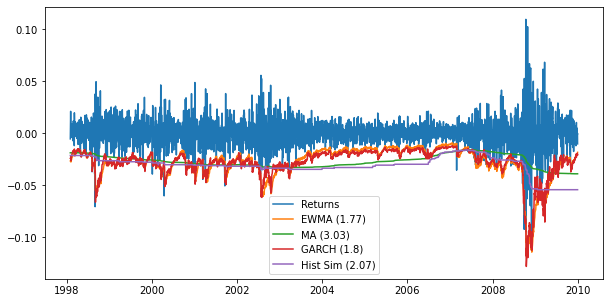

In [8]:
#Plot VaR vs Returns
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(ret_ex1[VaR99.index],label='Returns')
ax.plot(-VaR99['EWMA'],label='EWMA ('+str(VR['VR'].loc['EWMA'])+')')
ax.plot(-VaR99['MA'],label='MA ('+str(VR['VR'].loc['MA'])+')')
ax.plot(-VaR99['GARCH'],label='GARCH ('+str(VR['VR'].loc['GARCH'])+')')
ax.plot(-VaR99['Hist Simulation'],label='Hist Sim ('+str(VR['VR'].loc['Hist Simulation'])+')')
plt.legend(loc=0)
plt.show()

In [9]:
#Unconditional coverage test
print('EWMA:',uncov_test(ret_ex1[VaR99.index],30,0.01,VaR99['EWMA']))
print('MA:',uncov_test(ret_ex1[VaR99.index],30,0.01,VaR99['MA']))
print('GARCH:',uncov_test(ret_ex1[VaR99.index],30,0.01,VaR99['GARCH']))
print('Hist Simulation:',uncov_test(ret_ex1[VaR99.index],30,0.01,VaR99['Hist Simulation']))

EWMA: (-12.03, 0.0)
MA: (-56.69, 0.0)
GARCH: (-12.93, 0.0)
Hist Simulation: (-20.79, 0.0)


In [10]:
#Restimating Violation Ratios dropping last 1000 observations
exp_except=2000*0.01

VR=pd.DataFrame(columns=['VR','VaR vol'],index=VaR99.columns)
for col in VaR99.columns:
    VR['VR'].loc[col]=round(sum((ret_ex1.loc[VaR99.index[:-1000]]<-VaR99[col].iloc[:-1000])*1)/exp_except,2)
    VR['VaR vol'].loc[col]=VaR99[col].iloc[:-1000].std()

VR

,VR,VaR vol
EWMA,1.45,0.010036
MA,1.6,0.0039334
GARCH,1.15,0.0082622
Hist Simulation,1.1,0.00349947


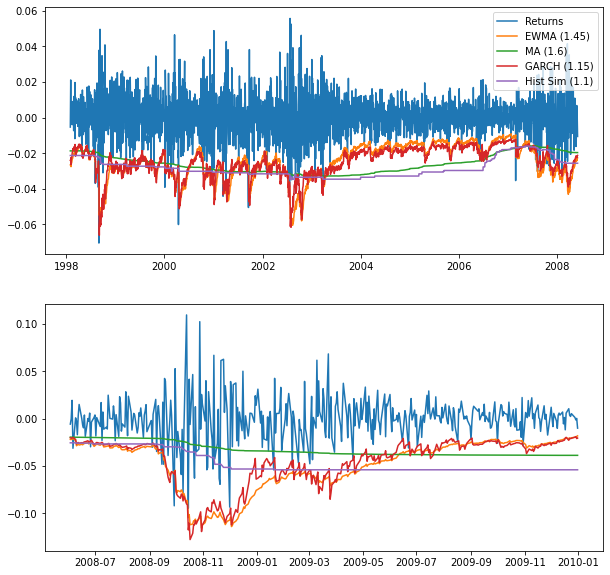

In [11]:
#Plot VaR vs Returns
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(ret_ex1[VaR99.index[:-400]],label='Returns')
ax[0].plot(-VaR99['EWMA'].iloc[:-400],label='EWMA ('+str(VR['VR'].loc['EWMA'])+')')
ax[0].plot(-VaR99['MA'].iloc[:-400],label='MA ('+str(VR['VR'].loc['MA'])+')')
ax[0].plot(-VaR99['GARCH'].iloc[:-400],label='GARCH ('+str(VR['VR'].loc['GARCH'])+')')
ax[0].plot(-VaR99['Hist Simulation'].iloc[:-400],label='Hist Sim ('+str(VR['VR'].loc['Hist Simulation'])+')')
ax[0].legend(loc=0)

ax[1].plot(ret_ex1[VaR99.index[-400:]],label='Returns')
ax[1].plot(-VaR99['EWMA'].iloc[-400:],label='EWMA ('+str(VR['VR'].loc['EWMA'])+')')
ax[1].plot(-VaR99['MA'].iloc[-400:],label='MA ('+str(VR['VR'].loc['MA'])+')')
ax[1].plot(-VaR99['GARCH'].iloc[-400:],label='GARCH ('+str(VR['VR'].loc['GARCH'])+')')
ax[1].plot(-VaR99['Hist Simulation'].iloc[-400:],label='Hist Sim ('+str(VR['VR'].loc['Hist Simulation'])+')')
plt.show()

In [12]:
#Unconditional coverage test 
print('EWMA:',uncov_test(ret_ex1[VaR99.index[:-1000]],20,0.01,VaR99['EWMA'].iloc[:-1000]))
print('MA:',uncov_test(ret_ex1[VaR99.index[:-1000]],20,0.01,VaR99['MA'].iloc[:-1000]))
print('GARCH:',uncov_test(ret_ex1[VaR99.index[:-1000]],20,0.01,VaR99['GARCH'].iloc[:-1000]))
print('Hist Simulation:',uncov_test(ret_ex1[VaR99.index[:-1000]],20,0.01,VaR99['Hist Simulation'].iloc[:-1000]))

EWMA: (-3.18, 0.0)
MA: (-5.27, 0.0)
GARCH: (-0.41, 0.0)
Hist Simulation: (-0.19, 0.0)
